## Baixar imagens

In [2]:
import glob
import requests
import os
import urllib.parse

# Baixar as imagens automaticamente
AUTO_DOWNLOAD_IMAGES = True

def _extract_filename_from_url(url: str) -> str:
    """Extract the original filename from a URL"""
    parsed_url = urllib.parse.urlparse(url)
    path = parsed_url.path
    filename = os.path.basename(path)
    filename = filename.split('?')[0]
    return filename

def _baixar_imagem(url: str, path: str):
    """Download an image with its original filename"""
    img_data = requests.get(url).content
    filename = _extract_filename_from_url(url)
    filepath = os.path.join(path, filename)
    with open(filepath, 'wb') as handler:
        handler.write(img_data)
    return filename

def _configurar():
    if not os.path.exists('images'):
        os.makedirs('images')

    for file in glob.glob('images/*'):
        os.remove(file)

    path = 'images/'
    if not os.path.exists(path):
        os.makedirs(path)

    img_links = [
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/flowers.jpg?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/gecko.png?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/rice.tif?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/beans.png?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/blobs.png?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/chips.png?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/coffee.png?raw=true',
        'https://github.com/tfvieira/dip-2024-2/blob/main/img/dowels.tif?raw=true',
    ]


    image_files = glob.glob(f"{path}*.*")

    if AUTO_DOWNLOAD_IMAGES and len(image_files) < len(img_links):
        downloaded_files = []
        for i, link in enumerate(img_links):
            print(f"[LOG] Baixando {i} {link}")
            filename = _baixar_imagem(link, path)
            downloaded_files.append(os.path.join(path, filename))

        image_files = downloaded_files

    print(image_files)

_configurar()

[LOG] Baixando 0 https://github.com/tfvieira/dip-2024-2/blob/main/img/flowers.jpg?raw=true
[LOG] Baixando 1 https://github.com/tfvieira/dip-2024-2/blob/main/img/gecko.png?raw=true
[LOG] Baixando 2 https://github.com/tfvieira/dip-2024-2/blob/main/img/rice.tif?raw=true
[LOG] Baixando 3 https://github.com/tfvieira/dip-2024-2/blob/main/img/beans.png?raw=true
[LOG] Baixando 4 https://github.com/tfvieira/dip-2024-2/blob/main/img/blobs.png?raw=true
[LOG] Baixando 5 https://github.com/tfvieira/dip-2024-2/blob/main/img/chips.png?raw=true
[LOG] Baixando 6 https://github.com/tfvieira/dip-2024-2/blob/main/img/coffee.png?raw=true
[LOG] Baixando 7 https://github.com/tfvieira/dip-2024-2/blob/main/img/dowels.tif?raw=true
['images/flowers.jpg', 'images/gecko.png', 'images/rice.tif', 'images/beans.png', 'images/blobs.png', 'images/chips.png', 'images/coffee.png', 'images/dowels.tif']




---



### Flowers.jpg

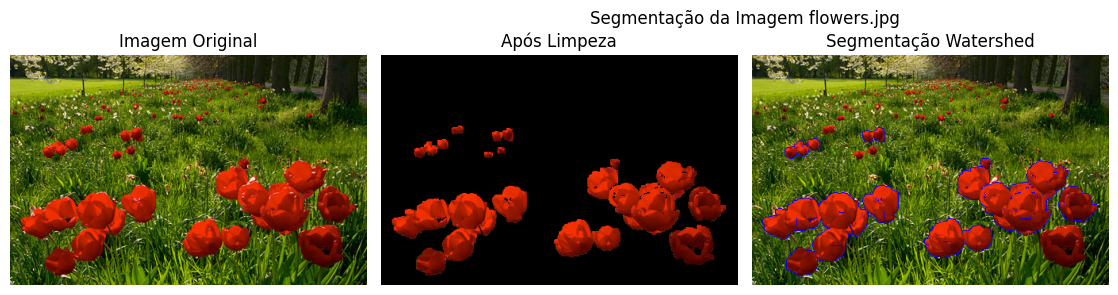

/var/folders/cy/t5kz61bn42lb3r8vhh47vv580000gn/T/ipykernel_40627/1486806470.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


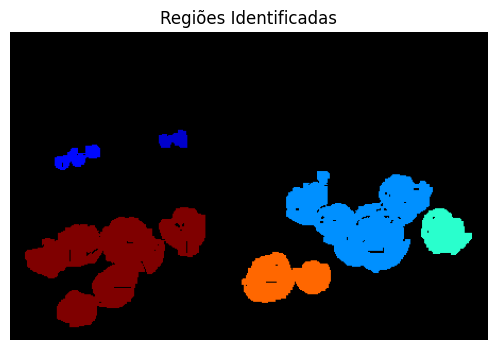

Processamento da imagem flowers.jpg concluído!
Os resultados foram salvos no diretório: segmented_images


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import filters, morphology
from scipy import ndimage as ndi

output_dir = "segmented_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

filename = "flowers.jpg"
image_path = "images/" + filename
image = cv2.imread(image_path)

if image is None:
    print(f"Erro: Não foi possível carregar a imagem {image_path}")
else:
    def preprocess_flowers(image, threshold=100, y_cutoff=None):
        b, g, r = cv2.split(image)
        mask = r > threshold
        mask2 = g < 70
        mask3 = b < 90
        result = image.copy()
        result[~mask] = 0
        result[~mask2] = 0
        result[~mask3] = 0

        if y_cutoff is not None:
            result[:y_cutoff, :, :] = 0

        return result

    preprocessed_image = preprocess_flowers(image, threshold=50, y_cutoff=80)

    def apply_morphological_operations(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3, 3), np.uint8)

        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=2)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

        result = img.copy()
        mask = closing > 0
        for c in range(3):
            result[:,:,c] = result[:,:,c] * mask

        return result

    preprocessed_clean = apply_morphological_operations(preprocessed_image)

    def skimage_watershed_segmentation(image, processed_image, blur_sigma=3.0, min_distance=20, min_size=100):
        processed_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)

        smooth = filters.gaussian(gray, sigma=blur_sigma)
        gradient = filters.sobel(smooth)

        distance = ndi.distance_transform_edt(gray > 0)

        coords = peak_local_max(distance, min_distance=min_distance, labels=gray > 0)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers = ndi.label(mask)[0]

        labels = watershed(gradient, markers, mask=gray > 0)

        filtered_labels = np.zeros_like(labels)
        for i in range(1, labels.max() + 1):
            region = labels == i
            if np.sum(region) >= min_size:
                filtered_labels[region] = i

        result = image.copy()

        boundaries = np.zeros_like(filtered_labels, dtype=bool)
        for i in range(1, filtered_labels.max() + 1):
            boundary = ndi.binary_dilation(filtered_labels == i) & ~(filtered_labels == i)
            boundaries = boundaries | boundary

        result[boundaries, :] = [255, 0, 0]

        return filtered_labels, result

    markers, result = skimage_watershed_segmentation(
        image,
        preprocessed_clean,
        blur_sigma=7.0,
        min_distance=25,  # Distância mínima entre picos
        min_size=150,      # Tamanho mínimo de região para manter
    )

    plt.figure(figsize=(15, 3))
    plt.subplot(141)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(cv2.cvtColor(preprocessed_clean, cv2.COLOR_BGR2RGB))
    plt.title('Após Limpeza')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Segmentação Watershed')
    plt.axis('off')

    plt.suptitle('Segmentação da Imagem flowers.jpg')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename}_watershed_skimage.png")
    plt.show()

    def show_regions(markers, image):
        from matplotlib import cm
        regions = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

        cmap = cm.get_cmap('jet')

        max_marker = np.max(markers) if np.max(markers) > 0 else 1

        for i in range(1, max_marker + 1):
            color = cmap(i / max_marker)[:3]
            color = [int(c * 255) for c in color]

            regions[markers == i] = color

        plt.figure(figsize=(8, 4))
        plt.imshow(regions)
        plt.title('Regiões Identificadas')
        plt.axis('off')
        plt.savefig(f"{output_dir}/{filename}_regions_skimage.png")
        plt.show()

    show_regions(markers, image)

    print(f"Processamento da imagem flowers.jpg concluído!")
    print(f"Os resultados foram salvos no diretório: {output_dir}")

### gecko.png

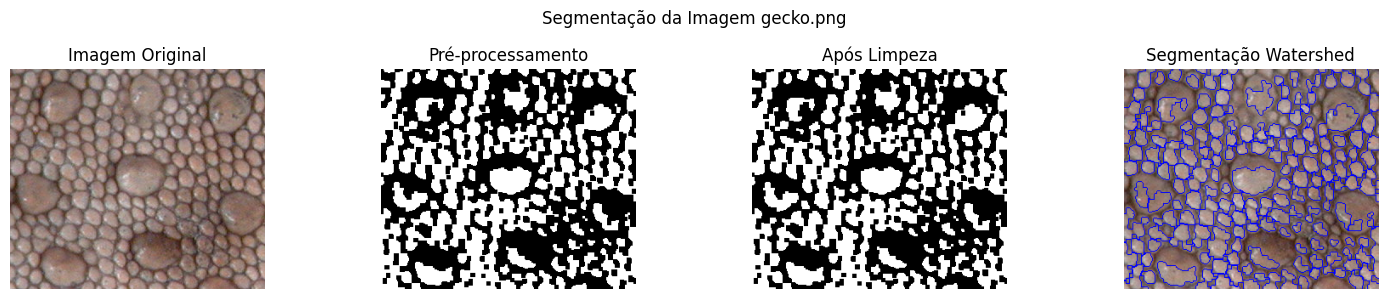

/var/folders/cy/t5kz61bn42lb3r8vhh47vv580000gn/T/ipykernel_40627/303370190.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


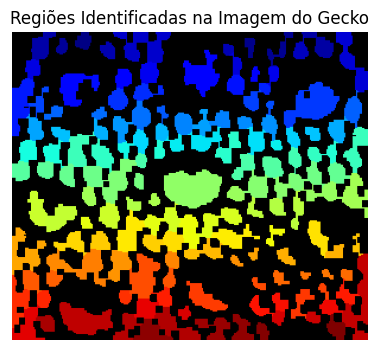

Processamento da imagem gecko.png concluído!
Os resultados foram salvos no diretório: segmented_images


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import filters, morphology
from scipy import ndimage as ndi

output_dir = "segmented_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

filename = "gecko.png"
image_path = "images/" + filename
image = cv2.imread(image_path)

if image is None:
    print(f"Erro: Não foi possível carregar a imagem {image_path}")
else:
    def preprocess_gecko(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        _, binary = cv2.threshold(enhanced, 150, 255, cv2.THRESH_BINARY)
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
        result = cv2.cvtColor(closing, cv2.COLOR_GRAY2BGR)
        return result

    preprocessed_image = preprocess_gecko(image)

    def apply_morphological_operations(img):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=1)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
        result = img.copy()
        mask = closing > 0
        if len(img.shape) == 3:
            for c in range(3):
                result[:,:,c] = result[:,:,c] * mask
        else:
            result = result * mask
            result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
        return result

    def skimage_watershed_segmentation(image, processed_image, blur_sigma=3.0, min_distance=20, min_size=100):
        processed_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
        smooth = filters.gaussian(gray, sigma=blur_sigma)
        gradient = filters.sobel(smooth)
        distance = ndi.distance_transform_edt(gray > 0)
        coords = peak_local_max(distance, min_distance=min_distance, labels=gray > 0)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers = ndi.label(mask)[0]
        labels = watershed(gradient, markers, mask=gray > 0)
        filtered_labels = np.zeros_like(labels)
        for i in range(1, labels.max() + 1):
            region = labels == i
            if np.sum(region) >= min_size:
                filtered_labels[region] = i
        result = image.copy()
        boundaries = np.zeros_like(filtered_labels, dtype=bool)
        for i in range(1, filtered_labels.max() + 1):
            boundary = ndi.binary_dilation(filtered_labels == i) & ~(filtered_labels == i)
            boundaries = boundaries | boundary
        result[boundaries, :] = [255, 0, 0]
        return filtered_labels, result

    preprocessed_clean = apply_morphological_operations(preprocessed_image)

    markers, result = skimage_watershed_segmentation(
        image,
        preprocessed_clean,
        blur_sigma=2.0,
        min_distance=10,
        min_size=40,
    )

    plt.figure(figsize=(15, 3))
    plt.subplot(141)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
    plt.title('Pré-processamento')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(cv2.cvtColor(preprocessed_clean, cv2.COLOR_BGR2RGB))
    plt.title('Após Limpeza')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Segmentação Watershed')
    plt.axis('off')

    plt.suptitle('Segmentação da Imagem '+filename)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename}_watershed_skimage.png")
    plt.show()

    def show_regions(markers, image):
        from matplotlib import cm
        regions = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        cmap = cm.get_cmap('jet')
        max_marker = np.max(markers) if np.max(markers) > 0 else 1
        for i in range(1, max_marker + 1):
            color = cmap(i / max_marker)[:3]
            color = [int(c * 255) for c in color]
            regions[markers == i] = color
        plt.figure(figsize=(8, 4))
        plt.imshow(regions)
        plt.title('Regiões Identificadas na Imagem do Gecko')
        plt.axis('off')
        plt.savefig(f"{output_dir}/{filename}_regions_skimage.png")
        plt.show()

    show_regions(markers, image)
    print(f"Processamento da imagem gecko.png concluído!")
    print(f"Os resultados foram salvos no diretório: {output_dir}")


## Usando Watershed



Iniciando segmentação de imagens com pré-processamento...
Processando flowers.jpg...


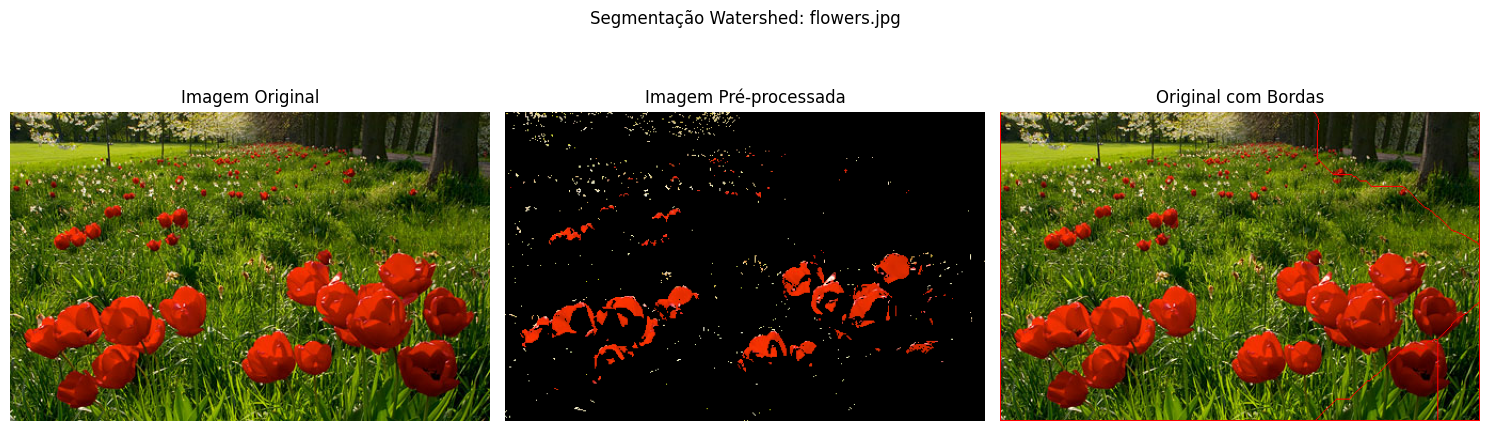

Processando gecko.png...


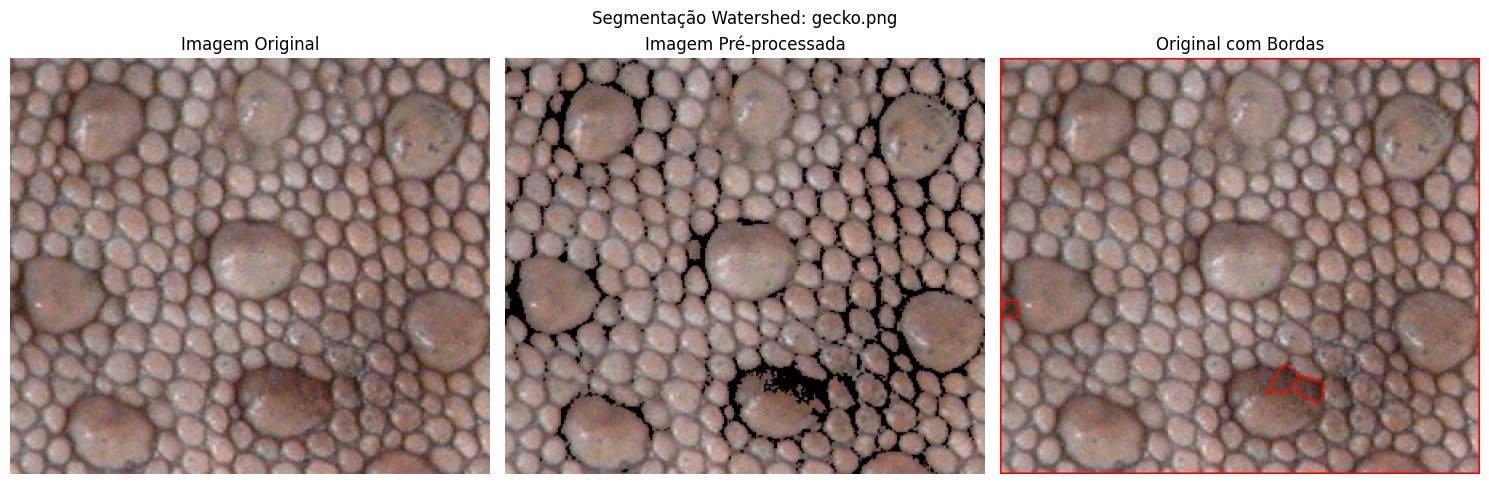

Processando rice.tif...


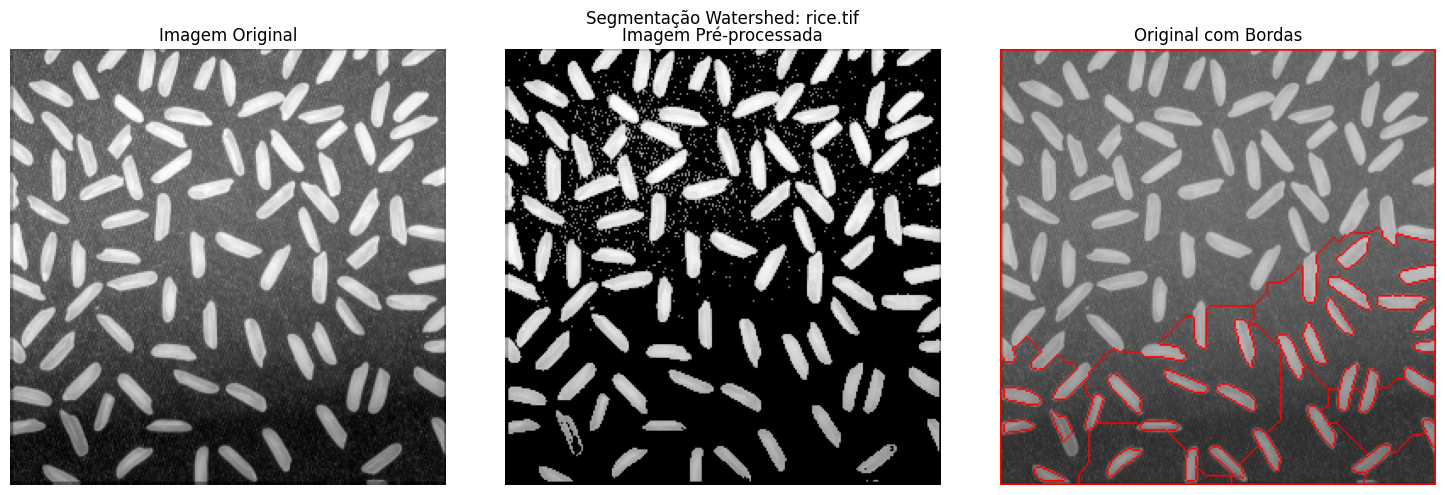

Processando beans.png...


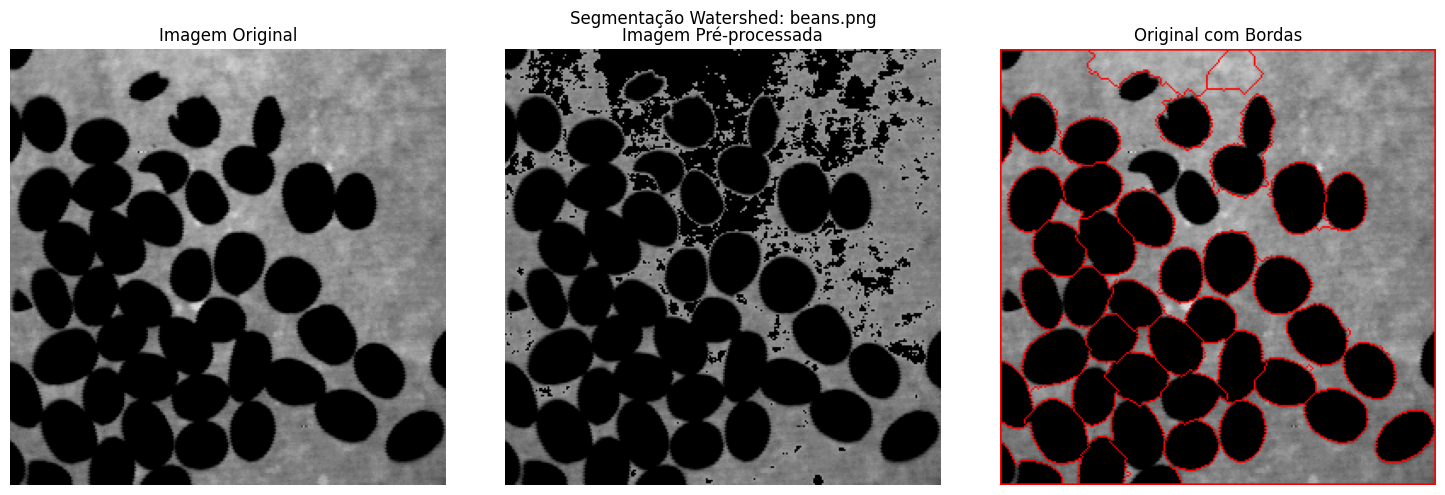

Processando blobs.png...


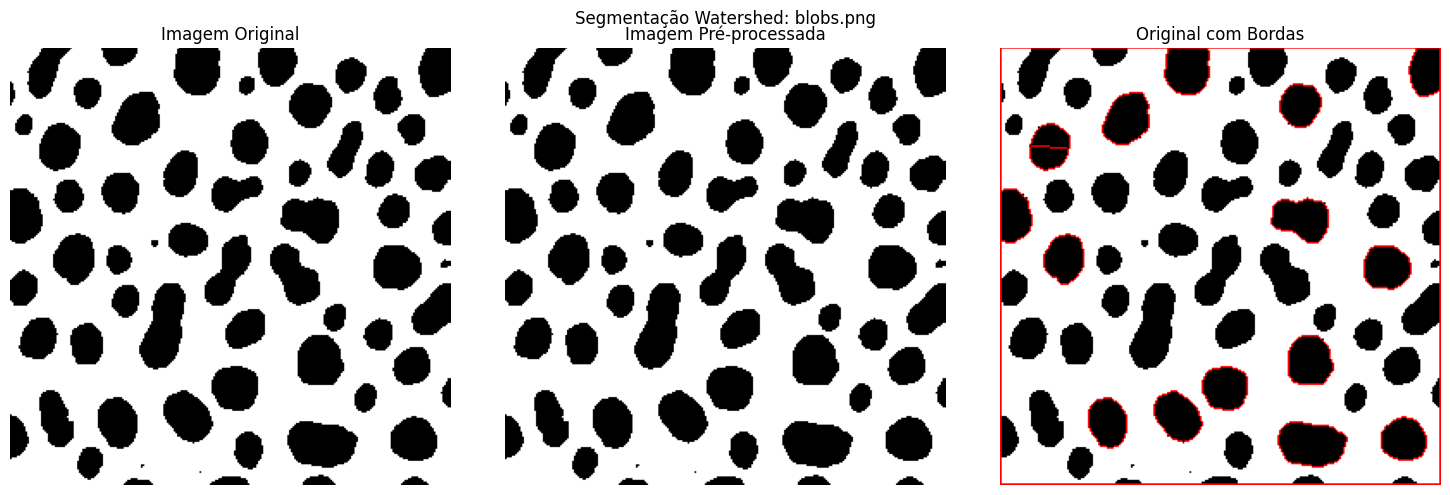

Processando chips.png...


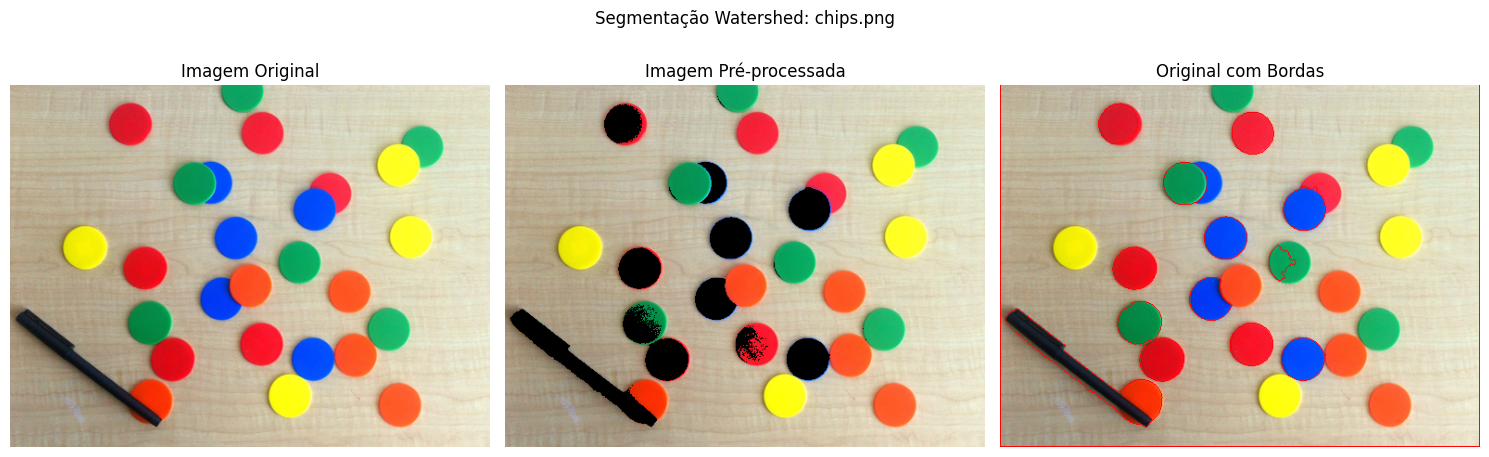

Processando coffee.png...


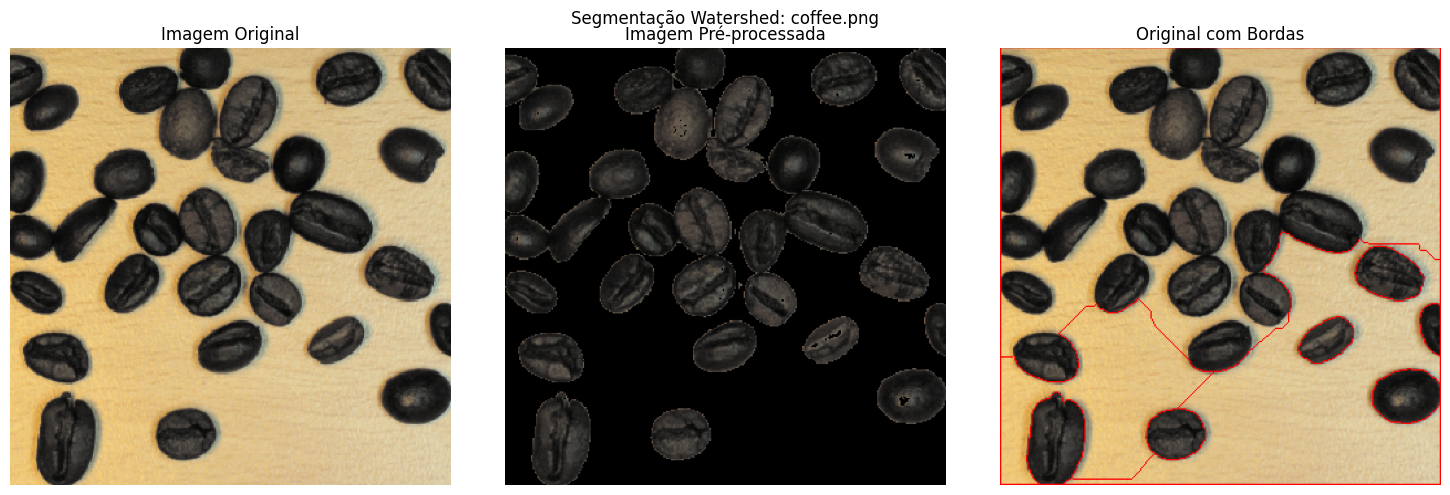

Processando dowels.tif...


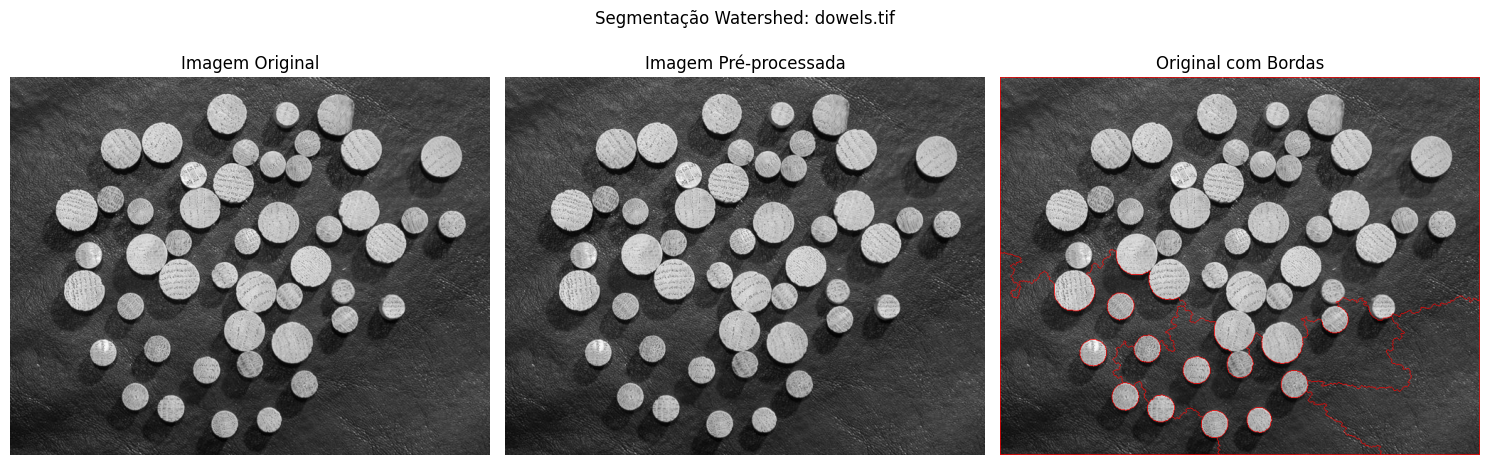

Processamento concluído! Imagens segmentadas salvas em: segmented_images


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import segmentation, color
import os

output_dir = "segmented_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def preprocess_image(image, filename, preprocess_params):
    if filename == "flowers.jpg":
        b, g, r = cv2.split(image)
        mask = r > preprocess_params['threshold']
        result = image.copy()
        result[~mask] = 0
        return result

    elif filename == "gecko.png":
        # Special processing for gecko.png
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Use CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        # Adaptive thresholding works better for texture patterns
        binary = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        result = image.copy()
        mask = binary > 0
        for c in range(3):
            result[:,:,c] = result[:,:,c] * mask
        return result

    elif filename == "rice.tif" or filename == "chips.png":
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        mask = gray > preprocess_params['threshold']
        result = image.copy()
        if len(image.shape) == 3:
            result[~mask] = 0
        else:
            result[~mask] = 0
        return result

    elif filename == "beans.png" or filename == "coffee.png":
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        mask = gray < preprocess_params['threshold']
        result = image.copy()
        if len(image.shape) == 3:
            result[~mask] = 0
        else:
            result[~mask] = 0
        return result

    elif filename == "blobs.png" or filename == "dowels.tif":
        return image

    else:
        return image

def watershed_segmentation(image, processed_image, filename, params):
    if len(processed_image.shape) == 3:
        gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = processed_image

    smooth = cv2.GaussianBlur(gray, (params['blur_kernel'], params['blur_kernel']), 0)

    sobelx = cv2.Sobel(smooth, cv2.CV_64F, 1, 0, ksize=params['sobel_kernel'])
    sobely = cv2.Sobel(smooth, cv2.CV_64F, 0, 1, ksize=params['sobel_kernel'])
    gradient = cv2.magnitude(sobelx, sobely)
    gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((params['morph_kernel'], params['morph_kernel']), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=params['opening_iterations'])

    sure_bg = cv2.dilate(opening, kernel, iterations=params['dilation_iterations'])

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, params['dist_threshold'] * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    if len(processed_image.shape) == 3:
        markers = cv2.watershed(processed_image, markers)
    else:
        colored = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
        markers = cv2.watershed(colored, markers)

    original_with_borders = image.copy()
    if len(image.shape) == 3:
        original_with_borders[markers == -1] = [0, 0, 255]
    else:
        original_with_borders = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        original_with_borders[markers == -1] = [0, 0, 255]

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(132)
    if len(processed_image.shape) == 3:
        plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(processed_image, cmap='gray')
    plt.title('Imagem Pré-processada')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(original_with_borders, cv2.COLOR_BGR2RGB))
    plt.title('Original com Bordas')
    plt.axis('off')

    plt.suptitle(f'Segmentação Watershed: {filename}')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename}_watershed.png")
    plt.show()

    return markers

def process_images():
    image_files = ["flowers.jpg", "gecko.png", "rice.tif", "beans.png",
                  "blobs.png", "chips.png", "coffee.png", "dowels.tif"]

    image_params = {
        "flowers.jpg": {
            'blur_kernel': 5,
            'sobel_kernel': 3,
            'morph_kernel': 3,
            'opening_iterations': 2,
            'dilation_iterations': 3,
            'dist_threshold': 0.6
        },
        "gecko.png": {
            'blur_kernel': 7,
            'sobel_kernel': 5,
            'morph_kernel': 3,
            'opening_iterations': 3,
            'dilation_iterations': 4,
            'dist_threshold': 0.5
        },
        "rice.tif": {
            'blur_kernel': 3,
            'sobel_kernel': 3,
            'morph_kernel': 3,
            'opening_iterations': 1,
            'dilation_iterations': 2,
            'dist_threshold': 0.7
        },
        "beans.png": {
            'blur_kernel': 5,
            'sobel_kernel': 3,
            'morph_kernel': 3,
            'opening_iterations': 2,
            'dilation_iterations': 3,
            'dist_threshold': 0.65
        },
        "blobs.png": {
            'blur_kernel': 3,
            'sobel_kernel': 3,
            'morph_kernel': 3,
            'opening_iterations': 1,
            'dilation_iterations': 2,
            'dist_threshold': 0.7
        },
        "chips.png": {
            'blur_kernel': 5,
            'sobel_kernel': 3,
            'morph_kernel': 5,
            'opening_iterations': 2,
            'dilation_iterations': 3,
            'dist_threshold': 0.6
        },
        "coffee.png": {
            'blur_kernel': 7,
            'sobel_kernel': 5,
            'morph_kernel': 5,
            'opening_iterations': 3,
            'dilation_iterations': 4,
            'dist_threshold': 0.5
        },
        "dowels.tif": {
            'blur_kernel': 3,
            'sobel_kernel': 3,
            'morph_kernel': 3,
            'opening_iterations': 2,
            'dilation_iterations': 2,
            'dist_threshold': 0.7
        }
    }

    preprocess_params = {
        "flowers.jpg": {'threshold': 200},
        "gecko.png": {'threshold': 80},
        "rice.tif": {'threshold': 117},
        "beans.png": {'threshold': 150},
        "blobs.png": {'threshold': 0},
        "chips.png": {'threshold': 90},
        "coffee.png": {'threshold': 100},
        "dowels.tif": {'threshold': 0}
    }

    image_dir = "images/"
    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        if os.path.exists(image_path):
            print(f"Processando {filename}...")

            if filename.endswith('.tif'):
                from skimage import io
                image = io.imread(image_path)
                if image.max() > 255:
                    image = (image / image.max() * 255).astype(np.uint8)
            else:
                image = cv2.imread(image_path)

            processed_image = preprocess_image(image, filename, preprocess_params[filename])
            watershed_segmentation(image, processed_image, filename, image_params[filename])
        else:
            print(f"Arquivo {image_path} não encontrado.")

    print(f"Processamento concluído! Imagens segmentadas salvas em: {output_dir}")

print("Iniciando segmentação de imagens com pré-processamento...")
process_images()



---



## SLIC - Simple Linear Iterative Clustering

O Skimage já possui uma função pronta para aplicarmos SLIC em uma imagem, adeptei o código do tutorial [GeeksForGeeks](https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/) para aplicar SLIC em todas as imagens (menos as .tif).

Processando flowers.jpg...


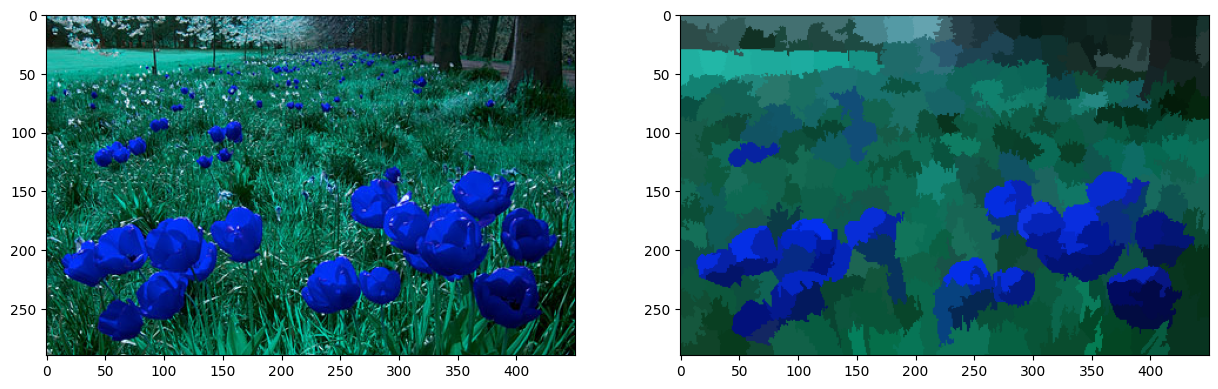

Processando gecko.png...


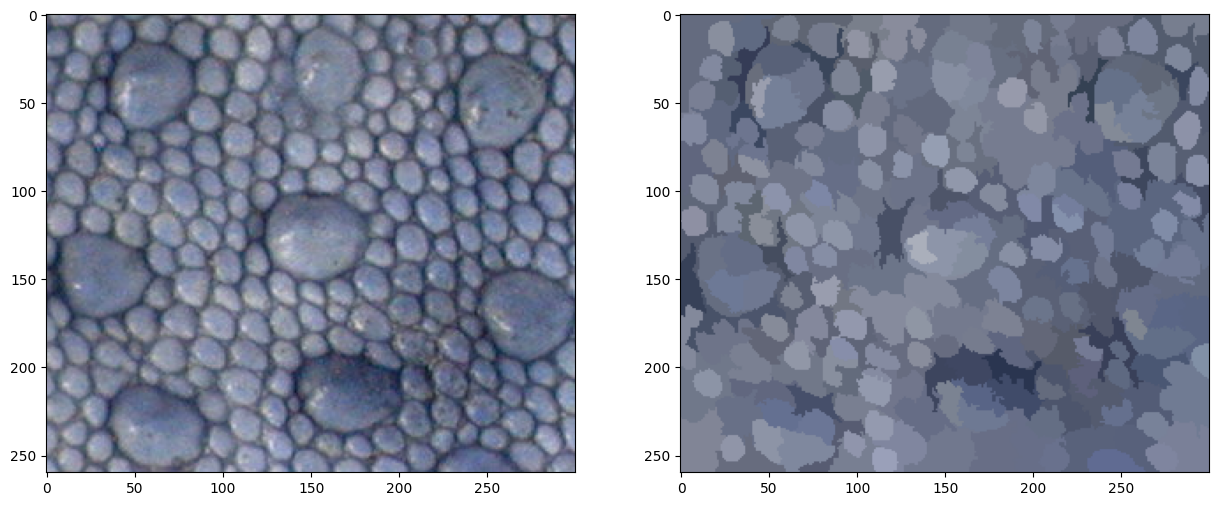

Processando rice.tif...


TypeError: Invalid shape (257, 257, 3, 3) for image data

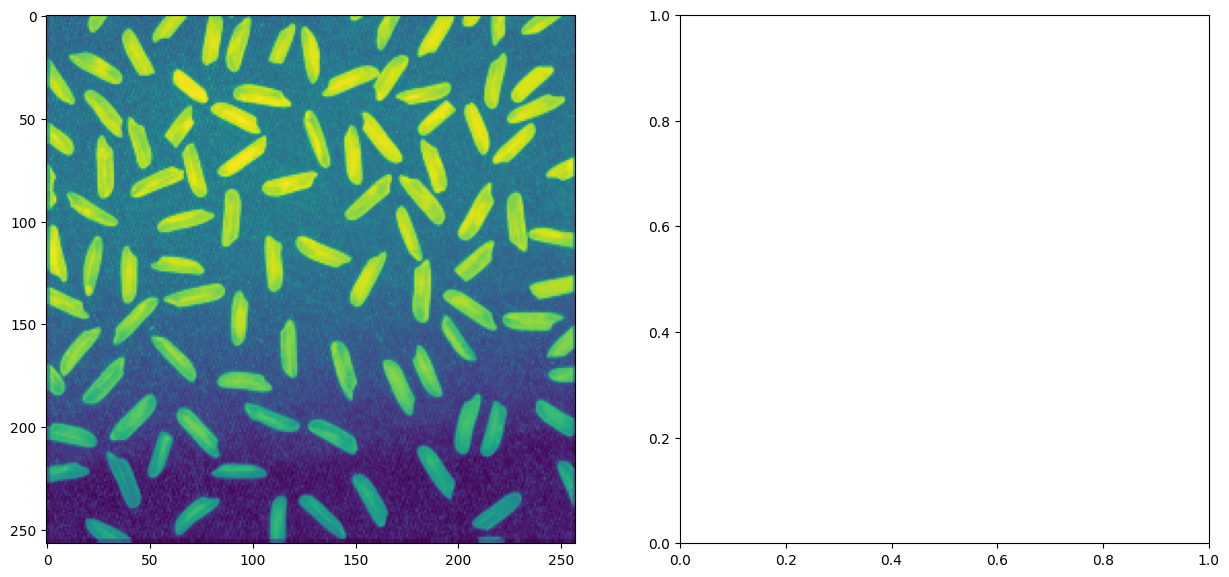

In [ ]:
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.color import label2rgb
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


image_files = ["flowers.jpg", "gecko.png", "rice.tif", "beans.png",
                  "blobs.png", "chips.png", "coffee.png", "dowels.tif"]

slic_arguments = [[400,15],[300,10],[100,50],[100,50],[100,50]]

def apply_slic(image, filename, i):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(image)

    # testa se a imagem é em tons de cinza
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        segments = slic(image, n_segments=slic_arguments[i][0], compactness=slic_arguments[i][1], channel_axis=None)
    else:
        segments = slic(image, n_segments=slic_arguments[i][0], compactness=slic_arguments[i][1])

    plt.subplot(1,2,2)

    plt.imshow(label2rgb(segments, image, kind = 'avg'))
    plt.show()


image_dir = "images/"
n = 0
for filename in image_files:
    image_path = os.path.join(image_dir, filename)
    if os.path.exists(image_path):
        print(f"Processando {filename}...")

        if filename.endswith('.tif'):
            from skimage import io
            image = io.imread(image_path)
            if image.max() > 255:
                image = (image / image.max() * 255).astype(np.uint8)
        else:
            image = cv2.imread(image_path)

        apply_slic(image, filename, n)
    else:
        print(f"Arquivo {image_path} não encontrado.")

    n += 1
